<h1>Food Delivery Times, Linear Regression</h1>

The Goal of this notebook is to create a linear regression algorithm that accurately predicts the delivery time of food to the customer.

<h3> Import Packages and Load Data </h3>


In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics as stats

df = pd.read_csv('Food_Delivery_Times.csv')

Display the first 5 rows of the dataframe

In [336]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


<h3>Clean Data</h3>

Find the unique values of the string colunns Weather, Traffic_Level, Time_of_Day, and Vehicle_Type. Then convert these to numerical columns.

In [337]:
uniqueWeather = df['Weather'].unique()
print('Weather Types: ', uniqueWeather)

uniqueTraffic = df['Traffic_Level'].unique()
print('Traffic Levels: ',uniqueTraffic)

uniqueTime = df['Time_of_Day'].unique()
print('Times of Day: ',uniqueTime)

uniqueVehicle = df['Vehicle_Type'].unique()
print('Vehicle Types: ',uniqueVehicle)

Weather Types:  ['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy' nan]
Traffic Levels:  ['Low' 'Medium' 'High' nan]
Times of Day:  ['Afternoon' 'Evening' 'Night' 'Morning' nan]
Vehicle Types:  ['Scooter' 'Bike' 'Car']


Scale the Options to 0,1,2,...,n 

In [338]:
df['Weather'] = df['Weather'].map({'Windy':0,'Clear':1, 'Foggy':2, 'Rainy':3,'Snowy':4})
df['Traffic_Level'] = df['Traffic_Level'].map({'Low':0,'Medium':1,'High':2})
df['Time_of_Day'] = df['Time_of_Day'].map({'Afternoon':0,'Evening':1,'Night':2,'Morning':3})
df['Vehicle_Type'] = df['Vehicle_Type'].map({'Scooter':0,'Bike':1,'Car':2})

Display the newly scaled dataframe

In [339]:
df.head(5)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,0.0,0.0,0.0,0,12,1.0,43
1,738,16.42,1.0,1.0,1.0,1,20,2.0,84
2,741,9.52,2.0,0.0,2.0,0,28,1.0,59
3,661,7.44,3.0,1.0,0.0,0,5,1.0,37
4,412,19.03,1.0,0.0,3.0,1,16,5.0,68


Find the correlations between the variables and the Delivery_Time_min column

In [340]:
correlations = df.corr()
correlations = correlations['Delivery_Time_min'].sort_values(ascending=False)
correlations

Delivery_Time_min         1.000000
Distance_km               0.780998
Preparation_Time_min      0.307350
Traffic_Level             0.190333
Weather                   0.181658
Vehicle_Type              0.032093
Time_of_Day              -0.007882
Order_ID                 -0.036650
Courier_Experience_yrs   -0.090433
Name: Delivery_Time_min, dtype: float64

<h3>Data Exploration</h3>

From the information above, it appears the highest correlation is the Distance_km. Lets investigate this further.

Split the variable of interest and the target variable into two numpy arrays.

In [342]:
split_index = int(len(X)*0.75)

X = df['Distance_km']
X = X.to_numpy()
X_train = X[:split_index]
X_test = X[split_index:]

y = df['Delivery_Time_min']
y = y.to_numpy()
y_train = y[:split_index]
y_test = y[split_index:]

print('X shape: ', X.shape)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X shape:  (1000,)
X_train shape:  (750,)
X_test shape:  (250,)
y_train shape:  (750,)
y_test shape:  (250,)


Text(0, 0.5, 'Time (minutes)')

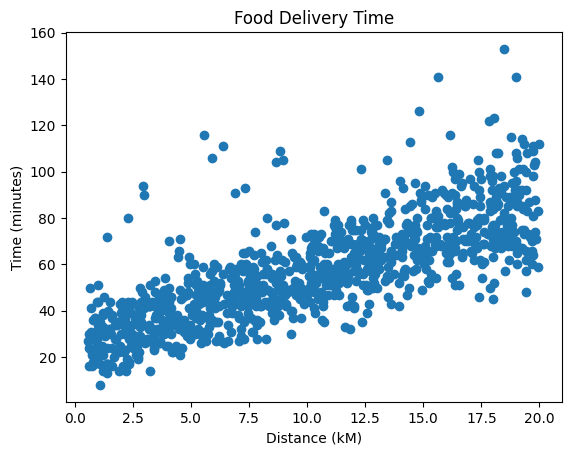

In [343]:
plt.scatter(X,y)
plt.title('Food Delivery Time')
plt.xlabel('Distance (kM)')
plt.ylabel('Time (minutes)')

Define, then compute the cost of the function.

The cost is the sum of the difference of the predicted value and the actual value, squared. This sum is then divided by the number of exmaples in the dataset. This represents the mean squared error per data point.

In [344]:
def compute_cost(X,y,w,b):
    
    m = X.shape[0]
    cost = 0

    for i in range(m):
        f_wb_i = np.dot(X[i],w) + b
        cost += (f_wb_i - y[i])**2
    
    cost = cost / (2*m)
    cost = cost[0]
    return cost

Set model parameters to 0 to test.

In [345]:
w = np.array([0])
b = 0

cost = compute_cost(X_train,y_train,w,b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))

Cost at initial w and b (zeros): 1838.964


Test with Non-Zero

In [346]:
w = np.array([0.5])
b = 2

cost = compute_cost(X_train,y_train,w,b)
print('Cost at initial w and b (zeros): {:.3f}'.format(cost))

Cost at initial w and b (zeros): 1423.633


Setting a weight decreases the cost! Lets continue to explore this further by defining the gradient then computing it.

In [347]:
def compute_gradient(X,y,w,b):
    
    m = X.shape[0]
    n = w.shape[0]
    
    dj_dw = np.zeros(w.shape)
    dj_db = 0

    if n == 1:
        for i in range(m):
            err_i = (np.dot(X[i],w) + b) - y[i]
            dj_dw = dj_dw + err_i*X[i]
            dj_db = dj_db + err_i
    
        dj_dw = dj_dw / m
        dj_db = dj_db / m

        dj_dw = dj_dw[0]
        dj_db = dj_db[0]

    else:
        
        for i in range(m):
            err_i = (np.dot(X[i],w) + b) - y[i]
            for j in range(n):
                dj_dw[j] = dj_dw[j] + err_i*X[i,j]
            dj_db = dj_db + err_i
    
        dj_dw = dj_dw / m
        dj_db = dj_db / m

    return dj_db, dj_dw

Test with Zeros

In [348]:
w = np.array([0])
b = 0

dj_db, dj_dw = compute_gradient(X_train,y_train,w,b)
print('dj_db at w and b = 0:', dj_db)
print('dj_dw at w and b = 0:', dj_dw)

dj_db at w and b = 0: -56.496
dj_dw at w and b = 0: -661.6324933333328


Test with Non-Zeros

In [349]:
w = np.array([0.5])
b = 2

dj_db, dj_dw = compute_gradient(X_train,y_train,w,b)
print('dj_db at w and b = 0:', dj_db)
print('dj_dw at w and b = 0:', dj_dw)

dj_db at w and b = 0: -49.49952666666661
dj_dw at w and b = 0: -575.7084633999999


Define gradient descent then compute the gradient descent

In [350]:
def gradient_descent(X,y,w,b,compute_cost,compute_gradient,alpha,num_iters):
    
    J_hist = []

    for i in range(num_iters):
        dj_db, dj_dw = compute_gradient(X,y,w,b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i < 100000:
            J_hist.append(compute_cost(X,y,w,b))
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            print(f"Iteration {i:d}: cost{J_hist[-1]: 0.2f}    ")

    w = w[0]

    return w, b, J_hist

Test with Zero

In [351]:
w = np.array([0])
b = 0
alpha = 0.0000001
num_iters = 1000

w_final, b_final, J_history = gradient_descent(X_train,y_train,w,b,compute_cost,compute_gradient,alpha,num_iters)

Iteration 0: cost 1838.92    
Iteration 100: cost 1834.52    
Iteration 200: cost 1830.12    
Iteration 300: cost 1825.74    
Iteration 400: cost 1821.38    
Iteration 500: cost 1817.02    
Iteration 600: cost 1812.67    
Iteration 700: cost 1808.34    
Iteration 800: cost 1804.02    
Iteration 900: cost 1799.71    
Iteration 999: cost 1795.45    


Test with Non-Zero

In [352]:
w = np.array([0.5])
b = 2
alpha = 0.0000001
num_iters = 1000

w_final, b_final, J_history = gradient_descent(X_train,y_train,w,b,compute_cost,compute_gradient,alpha,num_iters)
print()
print('Final w: ', w_final)
print('Final b: ', b_final)

Iteration 0: cost 1423.60    
Iteration 100: cost 1420.27    
Iteration 200: cost 1416.94    
Iteration 300: cost 1413.62    
Iteration 400: cost 1410.32    
Iteration 500: cost 1407.02    
Iteration 600: cost 1403.73    
Iteration 700: cost 1400.44    
Iteration 800: cost 1397.17    
Iteration 900: cost 1393.91    
Iteration 999: cost 1390.68    

Final w:  0.5571908224042168
Final b:  2.004921096494583


We got slightly better but not much.. Lets take a look at the scatter plot of the training data and the cost function over iterations.

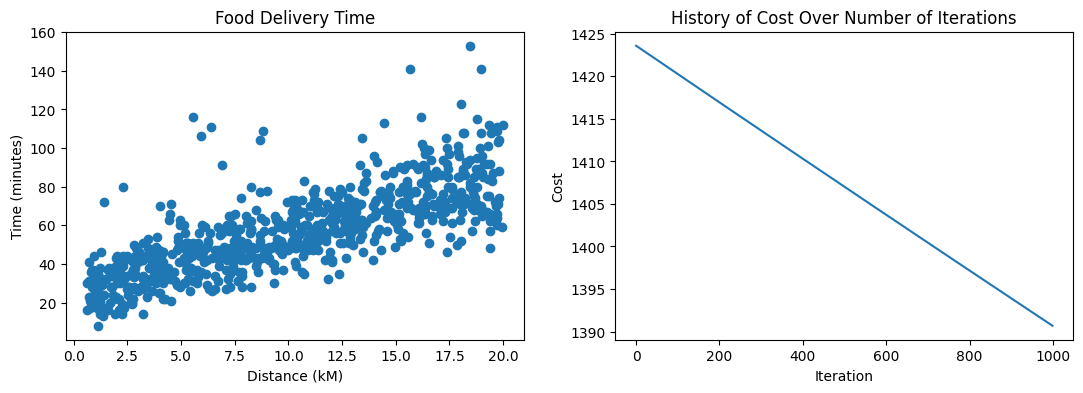

In [319]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

ax1.scatter(X_train, y_train)
ax1.set_title('Food Delivery Time')
ax1.set_xlabel('Distance (kM)')
ax1.set_ylabel('Time (minutes)')

ax2.plot(J_history)
ax2.set_title('History of Cost Over Number of Iterations')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Cost')

plt.show()

The previous gradient descent slope we set was 0.5 with an intercept of 2. Both of these are visibly off. I'd estimate the intercept to be roughly 15 and the slope to be 2.5.

The cost function does not decrease by much and is linear. We should see a steep dropoff that eventually converges.

To achieve better results, we can tweak the alpha (learning rate). Lets increase the size of alpha and keep the same parameters.

Note as we continue. The correlation between these two variables was 0.78, meaning there is a relationship although there won't be a perfect model to fit the data.

In [353]:
w = np.array([0.5]) 
b = 2
alpha = 0.007 #0.0000001
num_iters = 1000

w_final, b_final, J_history = gradient_descent(X_train,y_train,w,b,compute_cost,compute_gradient,alpha,num_iters)
print()
print('Final w: ', w_final)
print('Final b: ', b_final)

Iteration 0: cost 171.29    
Iteration 100: cost 145.06    
Iteration 200: cost 130.96    
Iteration 300: cost 120.90    
Iteration 400: cost 113.73    
Iteration 500: cost 108.62    
Iteration 600: cost 104.97    
Iteration 700: cost 102.37    
Iteration 800: cost 100.52    
Iteration 900: cost 99.20    
Iteration 999: cost 98.26    

Final w:  3.3657856224170226
Final b:  21.799960641412145


By just changing the alpha over the last two tests, we significantly decreased the cost function. As the cost continued to decrease near the 1000th iteration, lets run this again with a larger number of iterations.

In [354]:
w = np.array([0.5]) 
b = 2
alpha = 0.008 
num_iters = 3000

w_final, b_final, J_history = gradient_descent(X_train,y_train,w,b,compute_cost,compute_gradient,alpha,num_iters)
print()
print('Final w: ', w_final)
print('Final b: ', b_final)

Iteration 0: cost 169.50    
Iteration 300: cost 117.52    
Iteration 600: cost 102.69    
Iteration 900: cost 98.04    
Iteration 1200: cost 96.58    
Iteration 1500: cost 96.12    
Iteration 1800: cost 95.98    
Iteration 2100: cost 95.93    
Iteration 2400: cost 95.92    
Iteration 2700: cost 95.92    
Iteration 2999: cost 95.91    

Final w:  3.03732106503178
Final b:  26.126751698187395


The cost has decreased significantly since our first test! The first test had a cost of 1403 and now its 95.91.

Our final model parameters are:
**w = 3.0373**
**b = 26.1268**

Lets look at the history of the cost function over iterations

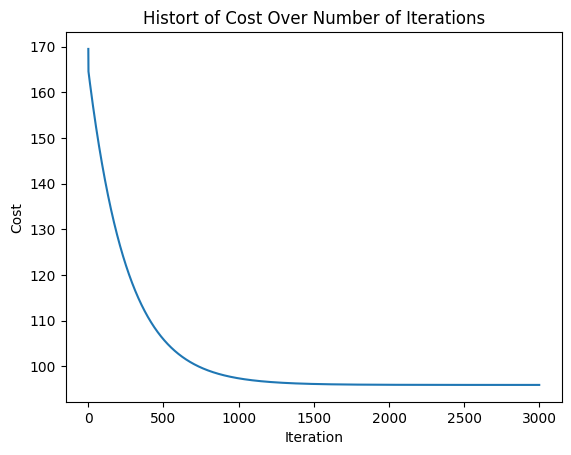

In [356]:
plt.plot(J_history)
plt.title('Histort of Cost Over Number of Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

Lets overlay the model with the scatter plot of the training data.

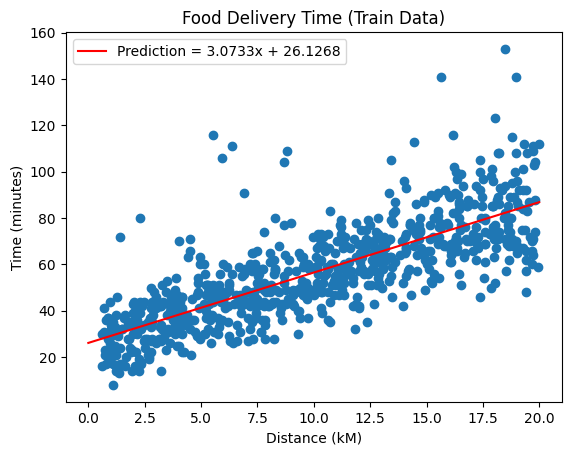

In [358]:
x = np.linspace(0,20,10)
predLine = w_final*x + b_final

plt.scatter(X_train,y_train)
plt.title('Food Delivery Time (Train Data)')
plt.xlabel('Distance (kM)')
plt.ylabel('Time (minutes)')

plt.plot(x,predLine, label='Prediction = 3.0733x + 26.1268',color='red')
plt.legend()
plt.show()

The slope and intercept we found looks accurate.

Lets test this on the training data.

<h3>Accuracy on Test Data</h3>
Lets define a predict function, then test it with our final model parameters.

In [359]:
def predict(X,w_final,b_final):
    m = X.shape[0]
    predictions = []
    for i in range(m):
        predictions.append(w_final*X[i] + b_final)

    return predictions

Compute the predictions

In [360]:
predictions = predict(X_test,w_final,b_final)

Create a scatter plot of the test dataset and predictions

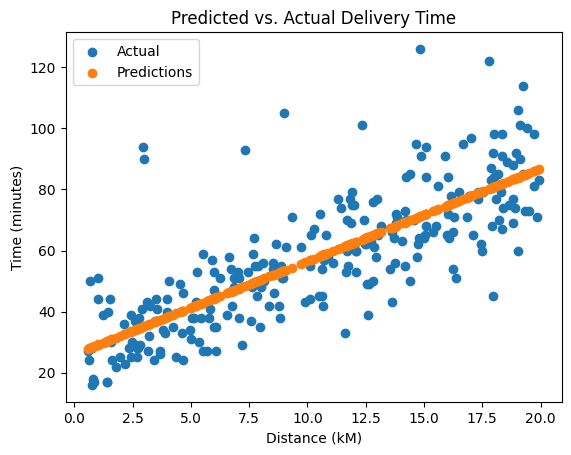

In [361]:
plt.scatter(X_test,y_test,label='Actual')
plt.scatter(X_test,predictions,label='Predictions')
plt.title('Predicted vs. Actual Delivery Time')
plt.xlabel('Distance (kM)')
plt.ylabel('Time (minutes)')
plt.legend()
plt.show()

Compute the difference of the prediction and actual, then plot the detla

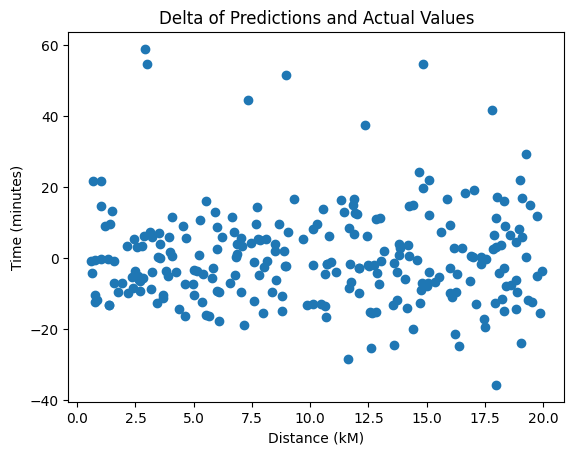

In [362]:
deltaPred = y_test - predictions
plt.title('Delta of Predictions and Actual Values')
plt.xlabel('Distance (kM)')
plt.ylabel('Time (minutes)')
plt.scatter(X_test,deltaPred)
plt.show()

The delta of the predictions and actual delivery times. A point at zero would be the best case, meaning the model perfectly predicted the delivery time.

A positive time means the actual value is higher than the prediction. A negative time means the prediction is higher than the actual value.

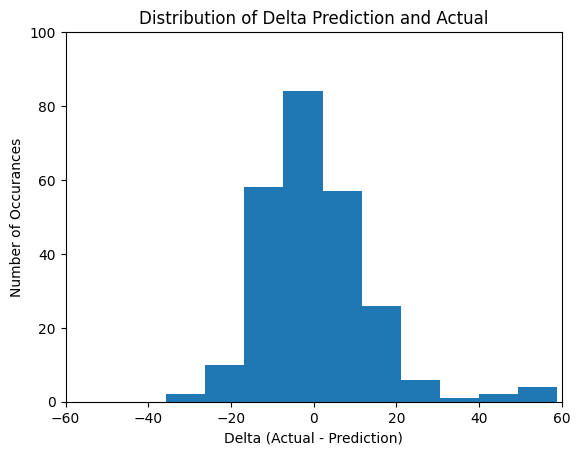

In [363]:
plt.hist(deltaPred,bins=10)
plt.title('Distribution of Delta Prediction and Actual')
plt.xlabel('Delta (Actual - Prediction)')
plt.ylabel('Number of Occurances')
plt.xlim(-60, 60)
plt.ylim(0,100)
plt.show()

A majority of the distribution falls within +/- 20 minutes of the actual value.

A positive time means the actual value is higher than the prediction. A negative time means the prediction is higher than the actual value.

Lets calculate a few statistics with this data.

In [364]:
Mean = round(stats.mean(deltaPred),3)
StandardDeviation = round(stats.stdev(deltaPred),3)
Median = round(stats.median(deltaPred),3)

print('Mean of the delta in actual and predicted value: ', Mean, 'minutes')
print('Median of the delta in actual and predicted value: ', Median, 'minutes')
print('Standard Deviation of the delta in actual and predicted value: ', StandardDeviation,'minutes')

Mean of the delta in actual and predicted value:  0.147 minutes
Median of the delta in actual and predicted value:  -1.645 minutes
Standard Deviation of the delta in actual and predicted value:  13.583 minutes


Lets compute a 1, 2, and 3 standard deviation from mean.

In [365]:
print('Mean of the delta in actual and predicted value: ', Mean)

sigmas = [1,2,3]
percentiles = ['68%','95%','99.7%']

for i in range(len(sigmas)):
    print(percentiles[i],' of predicted delivery times fell within +/-', round(Mean + StandardDeviation*sigmas[i],3), 'minutes of the actual delivered time')


Mean of the delta in actual and predicted value:  0.147
68%  of predicted delivery times fell within +/- 13.73 minutes of the actual delivered time
95%  of predicted delivery times fell within +/- 27.313 minutes of the actual delivered time
99.7%  of predicted delivery times fell within +/- 40.896 minutes of the actual delivered time


<h3>Summary</h3>

The strongest correlation to delivery time is the distance the delivery is from the resturaunt. This correlation was 0.78 on a 0-1 scale. Meaning there is a relationship between the two, although this relationship is subject to some spread in the data.

The dataset included 1000 samples and we isolated the distance feature to train a linear regression model. We split the data into four different groups: the X_train, X_test, y_train, and y_test.

We found the model parameters with the smallest cost without exhausing too much time or computing power. It is possible to reduce the cost more than we have, although this would require more time and for a small increase in accuracy.

This model is accurate with the data provided and could improve some currently existing delivery time estimaters.